In [ ]:
from __future__ import print_function
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import torch

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

Installing Altair...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-5uieoz05
  Running command git clone --filter=blob:none --quiet git://github.com/altair-viz/altair.git /tmp/pip-req-build-5uieoz05
  fatal: unable to connect to github.com:
  github.com[0: 20.27.177.113]: errno=Connection timed out

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet git://github.com/altair-viz/altair.git /tmp/pip-req-build-5uieoz05 did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet git://github.com/altair-viz/altair.git /tmp/pip-req-build-5uieoz05 did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and 

In [ ]:
torch.__version__

'1.13.1+cu116'

In [ ]:
# get cpu or gpu device for training
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [ ]:
# @title Load Data

In [ ]:
# Download news data from gdrive
!gdown --id 1RIxlDpe9Z2WRrH13n-Ve7DXEE03vdCEW

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RIxlDpe9Z2WRrH13n-Ve7DXEE03vdCEW
To: /content/NewsData.zip
100% 408k/408k [00:00<00:00, 104MB/s]


In [ ]:
import zipfile

print("Extracting news data")
# urlretrieve("https://drive.google.com/file/d/1RIxlDpe9Z2WRrH13n-Ve7DXEE03vdCEW/view?usp=share_link", "newsData.zip")
zip_ref = zipfile.ZipFile('NewsData.zip', "r")
zip_ref.extractall()
print("Done.")

Extracting news data
Done.


In [ ]:
from os import path

In [ ]:
data_root = 'NewsData'
def get_file_path(filename):
  return path.join(data_root, filename)

In [ ]:
# Load each data set (users, news, and ratings).
# users_cols = ['user_id']

users_df = pd.read_csv(
    get_file_path('users.csv'))
news_df = pd.read_csv(get_file_path('news.csv'))
ratings_df = pd.read_csv(get_file_path('ratings.csv'))
likes_df = pd.read_csv(get_file_path('likes.csv'))

In [ ]:
news_df.head()

,Id,Title,Category,Tags,Likes,Comments
0,23,Tuesday Morning,7,NaN,16,9
1,24,VMAs 2022,5,NaN,16,16
2,25,सन्दिप लामिछाने सर्वाधिक विकेट लिने खेलाडि,1,7,13,3
3,26,अभियन्ता उज्वल बिक्रम थापा एसिड सम्बन्धित कानु...,2,8,12,3
4,27,मोटरसाइकल वा स्कुटरमा मोबाइल होल्डर वा स्ट्यान...,3,NaN,15,13


In [ ]:
ratings_df.head()

,News,User,Like,Comment
0,23,7,1,1
1,23,8,1,1
2,23,12,1,0
3,23,16,1,1
4,23,18,1,1


In [ ]:
users_df.iloc[0]

User    1
Name: 0, dtype: int64

In [ ]:
# @title Data Preprocessing

In [ ]:
# add an id column beginning from 0
users_df["user_id"] = [i for i in range(users_df.shape[0])]
news_df["news_id"] = [i for i in range(news_df.shape[0])]

In [ ]:
# Count the ratings by deleted users
sum = 0
for i,x in enumerate(ratings_df["User"]):
  if len(users_df[users_df.User==x].index) != 1:
    # print(f"user {x} in of {i}th row")
    sum +=1
print(f"Total ratings to discard {sum}")

Total ratings to discard 36


In [ ]:
# remove user ratings associated to deleted users
ratings_df = ratings_df[ratings_df.User.isin(users_df.User)]

In [ ]:
# map user id to the index of the user in user table
ratings_df["news_id"] = ratings_df["News"].apply(lambda x: news_df[news_df.Id == x].index[0])

In [ ]:
# map news id to the index of the news table
ratings_df["user_id"] = ratings_df["User"].apply(lambda x: users_df[users_df.User == x].index[0])

In [ ]:
ratings_df.head()

,News,User,Like,Comment,news_id,user_id
0,23,7,1,1,0,3
1,23,8,1,1,0,4
2,23,12,1,0,0,8
3,23,16,1,1,0,12
4,23,18,1,1,0,14


In [ ]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [ ]:
news_df.head()

,Id,Title,Category,Tags,Likes,Comments,news_id
0,23,Tuesday Morning,7,NaN,16,9,0
1,24,VMAs 2022,5,NaN,16,16,1
2,25,सन्दिप लामिछाने सर्वाधिक विकेट लिने खेलाडि,1,7,13,3,2
3,26,अभियन्ता उज्वल बिक्रम थापा एसिड सम्बन्धित कानु...,2,8,12,3,3
4,27,मोटरसाइकल वा स्कुटरमा मोबाइल होल्डर वा स्ट्यान...,3,NaN,15,13,4


In [ ]:
news_df[news_df.Likes == 1798]

,Id,Title,Category,Tags,Likes,Comments,news_id
1713,1887,लोकप्रिय 'रुटिन अफ नेपाल बन्द'को मोबाइल एप सार...,3,899,1798,335,1713


In [ ]:
news_df.describe()

,Id,Category,Likes,Comments,news_id
count,3098.000,3098.000,3098.000,3098.000,3098.000
mean,1677.405,3.959,15.750,0.712,1548.500
std,956.301,4.064,46.515,6.514,894.460
min,23.000,1.000,0.000,0.000,0.000
25%,826.250,2.000,1.000,0.000,774.250
50%,1696.500,3.000,3.000,0.000,1548.500
75%,2512.750,3.000,19.000,0.000,2322.750
max,3297.000,47.000,1798.000,335.000,3097.000


In [ ]:
ratings_df[ratings_df.user_id==7171]

,News,User,Like,Comment,news_id,user_id
2568,1858,8062,1,0,1685,7171
2597,1859,8062,1,0,1686,7171
2633,1860,8062,1,0,1687,7171
2697,1862,8062,1,0,1689,7171
2747,1863,8062,1,0,1690,7171
...,...,...,...,...,...,...
48748,3226,8062,1,0,3027,7171
48757,3227,8062,1,0,3028,7171
48765,3228,8062,1,0,3029,7171
48774,3229,8062,1,0,3030,7171


In [ ]:
# @title find the user with most likes
ratings_by_user = ratings_df.groupby('user_id',as_index=False).count()
max_comment_index = ratings_by_user.Like.values.argmax()
max_comment_user_id = ratings_by_user.iloc[max_comment_index].user_id
users_df[users_df.user_id==max_comment_user_id]
# max_comment_user_id

,User,id
7171,8062,7171


In [ ]:
users_df.head()

,User,id
0,1,0
1,2,1
2,3,2
3,7,3
4,8,4


In [ ]:
users_df

,User,user_id
0,1,0
1,2,1
2,3,2
3,7,3
4,8,4
...,...,...
30757,33103,30757
30758,33104,30758
30759,33105,30759
30760,33106,30760


In [ ]:
# A function that generates a histogram of filtered data.
def filtered_hist(field, label, filter=None):
  """Creates a layered chart of histograms.
  The first layer (light gray) contains the histogram of the full data, and the
  second contains the histogram of the filtered data.
  Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(
      width=300,
  )
  if filter:
    return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
    ).resolve_scale(y='independent')
  return alt.layer(
      # base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')

In [ ]:
users_ratings = (
  ratings_df
  .groupby('user_id', as_index=False)
  .agg({'Like': ['count', 'mean']})
  .flatten_cols()
  .merge(users_df, on='user_id')
)
# Create a chart for the count, and one for the mean.
alt.hconcat(
filtered_hist('Like count', '# ratings / user'),
filtered_hist('Like mean', 'mean user rating'),
data=users_ratings)

alt.HConcatChart(...)

In [ ]:
news_ratings = news_df.merge(
    ratings_df
    .groupby('news_id', as_index=False)
    .agg({'Like': ['count', 'mean']})
    .flatten_cols(),
    on='news_id')
category_filter = alt.selection_multi(fields=['Category'])
category_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('Category'),
    color=alt.condition(
        category_filter,
        alt.Color("Category:N"),
        alt.value('lightgray'))
).properties(height=300, selection=category_filter)

In [ ]:
news_ratings.head()

,Id,Title,Category,Tags,Likes,Comments,news_id,Like count,Like mean
0,23,Tuesday Morning,7,NaN,16,9,0,17,0.941
1,24,VMAs 2022,5,NaN,16,16,1,17,0.941
2,25,सन्दिप लामिछाने सर्वाधिक विकेट लिने खेलाडि,1,7,13,3,2,13,1.000
3,26,अभियन्ता उज्वल बिक्रम थापा एसिड सम्बन्धित कानु...,2,8,12,3,3,12,1.000
4,27,मोटरसाइकल वा स्कुटरमा मोबाइल होल्डर वा स्ट्यान...,3,NaN,15,13,4,15,1.000


In [ ]:
(news_ratings[['Title', 'news_id', 'Like count', 'Like mean']]
 .sort_values('Like count', ascending=False)
 .head(10))

,Title,news_id,Like count,Like mean
1075,लोकप्रिय 'रुटिन अफ नेपाल बन्द'को मोबाइल एप सार...,1713,1884,0.954
1071,अभिषेक गिरीलाई भीमफेदी कारागार लैजाने बाटो खुल...,1709,580,0.948
1073,ट्याक्टर दुर्घटनामा २९ जना घाइते,1711,569,0.956
1076,सुकुम्बासी बस्ती व्यवस्थापन गर्न गृहमन्त्री ला...,1714,456,0.991
1074,होटल-रेष्टुरेन्टले सर्भिस चार्ज लिन नपाउने,1712,453,0.978
1070,अयोध्या लगिने देव शिलाको रुद्राभिशेकसहित बिदाइ,1708,445,0.980
1127,गृहमन्त्री रवि लामिछानेले दिए पदबाट राजीनामा,1766,356,0.972
1078,'काठमाडौं संस्कृति बचाउन युवा पुस्ता सक्रिय हु...,1716,347,0.974
1077,प्रेम आचार्यले नाम लिएका व्यक्तिहरुविरुद्ध प्र...,1715,305,0.984
1069,घनश्याम भूसाललाई महासचिव बनाउने एकीकृत समाजवाद...,1707,303,0.977


In [ ]:
# Display the number of ratings and average rating per movie.
alt.hconcat(
    filtered_hist('Like count', '# ratings / news', category_filter),
    filtered_hist('Like mean', 'mean news rating', category_filter),
    category_chart,
    data=news_ratings)

alt.HConcatChart(...)

In [ ]:
# @title Calculate rating of user
equal_weight_rating = lambda x: x.Like + (x.Comment+1)/(x.Comment+1)
ratings_df['rating'] = ratings_df[['Like', 'Comment']].apply(equal_weight_rating, axis=1)

In [ ]:
ratings_df.head(100)

,News,User,Like,Comment,news_id,user_id,rating
0,23,7,1,1,0,3,2.000
1,23,8,1,1,0,4,2.000
2,23,12,1,0,0,8,2.000
3,23,16,1,1,0,12,2.000
4,23,18,1,1,0,14,2.000
...,...,...,...,...,...,...,...
95,35,7,0,3,9,3,1.000
96,35,8,1,1,9,4,2.000
97,35,14,1,1,9,10,2.000
98,35,16,1,0,9,12,2.000


In [ ]:
def build_rating_sparse_tensor(ratings_df, users_df, items_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `news_id` and `rating` columns.
  Returns:
    A tf.SparseTensor representing the ratings matrix.
  """
  return torch.sparse_coo_tensor(
      indices=ratings_df[['user_id', 'news_id']].values.T.astype(int),
      values=ratings_df['rating'].values.astype('float32'),
      size=[users_df.shape[0], items_df.shape[0]]
  ).coalesce().to(device)

In [ ]:
def sparse_mean_square_error(true_ratings, predictions):
  """
  Args:
    true_ratings: Ground truth i.e flattened vector of ratings by the user
    predictions: Predicted ratings of the users for the items
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  # predictions = torch.sum(
  #     torch.gather(input=user_embeddings, index=sparse_ratings.indices[:, 0]) *
  #     torch.gather(input=movie_embeddings, index=sparse_ratings.indices[:, 1]),
  #     axis=1)
  loss = torch.nn.functional.mse_loss(predictions, true_ratings)
  return loss

In [ ]:
class CFModel(torch.nn.Module):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_dim, user_size, item_size, init_stddev=1., metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    super().__init__()
    self._metrics = metrics

    # Initialize the embeddings using a normal distribution.
    self.U = (torch.randn([user_size, embedding_dim]) * init_stddev).to(device).requires_grad_()
    self.V = (torch.randn([item_size, embedding_dim]) * init_stddev).to(device).requires_grad_()
  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return {
        "user_embed": self.U.detach().cpu().numpy(),
        "item_embed": self.V.detach().cpu().numpy()
    }

  def forward(self, sparse_ratings):
    predictions = torch.sum(
      torch.index_select(input=self.U,dim=0, index=sparse_ratings.indices()[0,:]) *
      torch.index_select(input=self.V,dim=0, index=sparse_ratings.indices()[1,:]),
      dim=1)
    return predictions

In [ ]:
def train(model: torch.nn.Module, ratings_mat, optimizer):
  """Trains the model.
  Args:
    model: model being trained
    rating_mat: sparse rating matrix of dense shape [N, M]
    optimizer: the optimizer to use
  Returns:
    The calculated loss during training
  """
  model.train()
  pred = model.forward(ratings_mat)
  # print(pred)
  loss = sparse_mean_square_error(ratings_mat.values(), pred)
  # print("****loss", loss)
  # Backpropagate error
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss

In [ ]:
def test(model: torch.nn.Module, rating_mat, optimizer):
  """Test the model.
  Args:
    iterations: number of iterations to run.
    learning_rate: optimizer learning rate.
    plot_results: whether to plot the results at the end of training.
    optimizer: the optimizer to use. Default to GradientDescentOptimizer.
  Returns:
    The metrics dictionary evaluated at the last iteration.
  """
  model.eval()
  with torch.no_grad():
    pred = model.forward(rating_mat)
    # print(pred.shape)
    loss = sparse_mean_square_error(rating_mat.values(), pred)  
  return loss

In [ ]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings, users_df, news_df)
  A_test = build_rating_sparse_tensor(test_ratings, users_df, news_df)

  # metrics = {
  #     'train_error': train_loss,
  #     'test_error': test_loss
  # }
  # embeddings = {
  #     "user_id": U,
  #     "movie_id": V
  # }
  return CFModel(
      embedding_dim, A_train.size()[0], A_train.size()[1], init_stddev
  ).to(device), A_train, A_test

In [ ]:
def run_training_session(A_train, A_test, model, train, optimizer_fn=torch.optim.SGD, num_iterations=100, learning_rate=1.0, plot_results=True):
  optimizer = optimizer_fn([model.U, model.V],lr=learning_rate)
  train_losses = []
  test_losses = []
  iterations = []
  for i in range(num_iterations+1):
    loss = train(model, A_train, optimizer)
    if (i%10 == 0) or (i == num_iterations):
      test_loss = test(model, A_test, optimizer)
      print(f'\r iteration {i}: train_error={loss} test_error={test_loss}', end='')
      iterations.append(i)
      # store the results in the plot
      train_losses.append(loss.detach().cpu().numpy())
      test_losses.append(test_loss.detach().cpu().numpy())
  #TODO: plot the losses vs iterations
  num_subplots = 1
  if plot_results:
    fig = plt.figure()
    fig.set_size_inches(num_subplots*10, 8)
    ax = fig.add_subplot(1, num_subplots, 1)
    ax.plot(iterations, train_losses, label='train_loss')
    ax.plot(iterations, test_losses, label='test_loss')
    ax.set_xlim([1, num_iterations])
    ax.legend()

 iteration 1000: train_error=0.020365722477436066 test_error=1.123795509338379
completed in 15.938415765762329


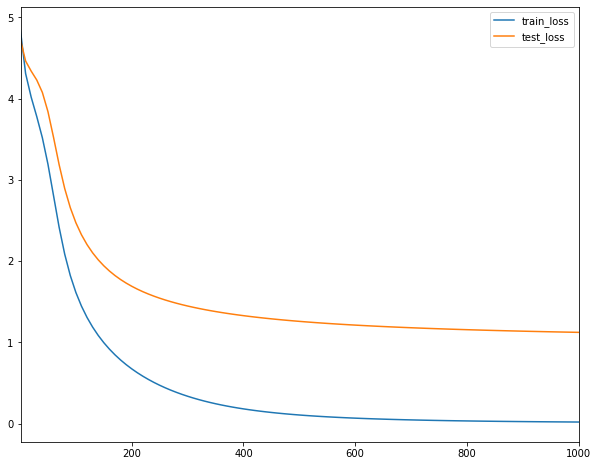

In [ ]:
import time

start = time.time()
# Build the CF model and train it.
model, A_train, A_test = build_model(ratings_df, embedding_dim=15, init_stddev=0.5)
# print(model)
run_training_session(A_train, A_test, model, train, num_iterations=1000, learning_rate=10., plot_results=True)
print(f'\ncompleted in {(time.time() - start)}')

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  scores = np.dot(item_embeddings, query_embedding)
  if measure == COSINE:
    u_norm = np.linalg.norm(query_embedding)
    V_norm = np.linalg.norm(item_embeddings, axis=1)
    norm_product = u_norm * V_norm
    scores = scores * (1. / norm_product)
  return scores

In [ ]:
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  user_id = 7171
  scores = compute_scores(
      model.embeddings["user_embed"][user_id],
      model.embeddings["item_embed"],
      measure
  )
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'item_id': news_df['news_id'],
      'titles': news_df['Title'],
      'categories': news_df['Category']
  })
  if exclude_rated:
    # remove the items that are already rated
    rated_items = ratings_df[ratings_df.user_id == user_id]["news_id"].values
    df = df[df.item_id.apply(lambda item_id: item_id not in rated_items)]
  display.display(df.sort_values([score_key], ascending=False).head(k))


def item_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for item ids that match the given substring
  ids = news_df[news_df['Title'].str.contains(title_substring)].index.values
  titles = news_df.iloc[ids]['Title'].values

  if len(titles) == 0:
    # raise ValueError("Found no movies with title %s" % title_substring)
    print("Found no movies with title %s" % title_substring)

  # print("Nearest neighbors of : %s." % titles[0])
  # if len(titles) > 1:
  #   print("[Found more than one matching movie. Other candidates: {}]".format(
  #       ", ".join(titles[1:])))

  item_id = 1709
  scores = compute_scores(
      model.embeddings['item_embed'][item_id], 
      model.embeddings['item_embed'],
      measure
  ) 
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': news_df['Title'],
      'categories': news_df['Category']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [ ]:
user_recommendations(model, measure=COSINE, k=5)

,cosine score,item_id,titles,categories
479,0.768,479,४ महिनामा नेपालले भारतलाई ८ अर्बको बिजुली बेच्यो,3
2618,0.718,2618,टेलिकमका श्रेणीविहीन कर्मचारीलाई सम्झौता गरी क...,3
2931,0.712,2931,टेलर स्विफ्ट बनिन् सबैभन्दा धेरै कमाउने महिला ...,3
2696,0.700,2696,फेरि नेपाल र भारतबीच अर्को बराबरी,1
2486,0.696,2486,श्रीलंका विजयी,1


In [ ]:
ratings_df.head()

,News,User,Like,Comment,news_id,user_id,rating
0,23,7,1,1,0,3,2.000
1,23,8,1,1,0,4,2.000
2,23,12,1,0,0,8,2.000
3,23,16,1,1,0,12,2.000
4,23,18,1,1,0,14,2.000


In [ ]:
item_neighbors(model, "Aladdin", DOT)
item_neighbors(model, "Aladdin", COSINE)

Found no movies with title Aladdin


,dot score,titles,categories
1709,9.042,अभिषेक गिरीलाई भीमफेदी कारागार लैजाने बाटो खुल...,12
1708,8.213,अयोध्या लगिने देव शिलाको रुद्राभिशेकसहित बिदाइ,3
1711,8.022,ट्याक्टर दुर्घटनामा २९ जना घाइते,3
1710,7.678,"क्यान इन्फोटेक माघ २४ देखि, ९० प्रतिशत ‘स्टल ब...",3
1713,7.584,लोकप्रिय 'रुटिन अफ नेपाल बन्द'को मोबाइल एप सार...,3
1704,7.519,काठमाडौं महानगरले हटायो अनधिकृत राखिएका ९ हजार...,3


Found no movies with title Aladdin


,cosine score,titles,categories
1709,1.000,अभिषेक गिरीलाई भीमफेदी कारागार लैजाने बाटो खुल...,12
1708,0.951,अयोध्या लगिने देव शिलाको रुद्राभिशेकसहित बिदाइ,3
1704,0.940,काठमाडौं महानगरले हटायो अनधिकृत राखिएका ९ हजार...,3
1711,0.935,ट्याक्टर दुर्घटनामा २९ जना घाइते,3
1702,0.930,वैशाख १ मा एकआपसमा भिड्दै पाँच नेपाली चलचित्र,5
1710,0.923,"क्यान इन्फोटेक माघ २४ देखि, ९० प्रतिशत ‘स्टल ब...",3


In [ ]:
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0]*V.shape[0]) * torch.sum(
      torch.matmul(U.T, U) * torch.matmul(V.T, V))
  
def get_square_norm(X):
  return (1./X.shape[0])*torch.sum(X*X)

def train_with_regularization(model: torch.nn.Module, ratings_mat, optimizer, regularization_coeff=.1, gravity_coeff=1.):
  """Trains the model.
  Args:
    model: model being trained
    rating_mat: sparse rating matrix of dense shape [N, M]
    optimizer: the optimizer to use
  Returns:
    The calculated loss during training
  """
  model.train()
  pred = model.forward(ratings_mat)
  # print(pred)
  loss = sparse_mean_square_error(ratings_mat.values(), pred)
  gravity_loss = gravity_coeff * gravity(model.U, model.V)
  regularization_loss = regularization_coeff * (get_square_norm(model.U) + get_square_norm(model.V))
  total_loss = loss + gravity_loss + regularization_loss
  # print("****loss", loss)
  # Backpropagate error
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  return loss

 iteration 2000: train_error=0.09063039720058441 test_error=0.5405802726745605
completed in 39.27825093269348


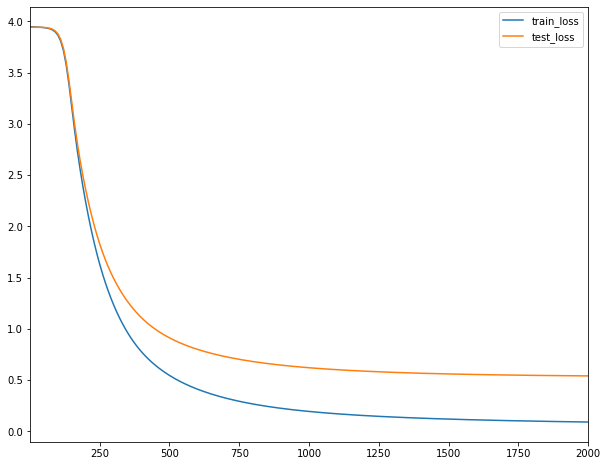

In [ ]:
start = time.time()
# Build the CF model and train it.
model, A_train, A_test = build_model(ratings_df, embedding_dim=15, init_stddev=0.05)
# print(model)
run_training_session(A_train, A_test, model, train_with_regularization, num_iterations=2000, learning_rate=5., plot_results=True)
print(f'\ncompleted in {(time.time() - start)}')

In [ ]:
user_recommendations(model, measure=COSINE, k=5)

,cosine score,item_id,titles,categories
2798,0.945,2798,दूधको मूल्य १० रुपैयाँले बढाउन प्रस्ताव,3
2921,0.944,2921,राष्ट्रपति निर्वाचन:आज अन्तिम नामावली प्रकाशन,2
2368,0.943,2368,माओवादी केन्द्रको वरीयतामा जनार्दनभन्दा वर्षमा...,2
2262,0.937,2262,प्रेम आचार्य प्रकरण: उपेन्द्र महतोसहित १२ जनास...,3
2724,0.937,2724,पूर्वराजाप्रति ओलीको टिप्पणी-'वरिपरि २–४ जना म...,2


In [ ]:
item_neighbors(model, "Aladdin", DOT)
item_neighbors(model, "Aladdin", COSINE)

Found no movies with title Aladdin


,dot score,titles,categories
1709,15.931,अभिषेक गिरीलाई भीमफेदी कारागार लैजाने बाटो खुल...,12
1707,11.871,घनश्याम भूसाललाई महासचिव बनाउने एकीकृत समाजवाद...,2
1708,11.858,अयोध्या लगिने देव शिलाको रुद्राभिशेकसहित बिदाइ,3
1706,11.476,कांग्रेस केन्द्रीय समितिको बैठक अनिश्चितकालका ...,2
1719,11.147,अझै सम्पन्न भएन राजा महेन्द्रले उद्घाटन गरेको ...,3
1703,10.672,बाबर लगातार आईसीसीको ओडीआई वर्ष खेलाडी घोषित,1


Found no movies with title Aladdin


,cosine score,titles,categories
1709,1.000,अभिषेक गिरीलाई भीमफेदी कारागार लैजाने बाटो खुल...,12
1707,0.888,घनश्याम भूसाललाई महासचिव बनाउने एकीकृत समाजवाद...,2
1706,0.882,कांग्रेस केन्द्रीय समितिको बैठक अनिश्चितकालका ...,2
1703,0.866,बाबर लगातार आईसीसीको ओडीआई वर्ष खेलाडी घोषित,1
1702,0.851,वैशाख १ मा एकआपसमा भिड्दै पाँच नेपाली चलचित्र,5
935,0.841,खेतीयोग्य जमिन अत्यन्तै न्यून भएको काठमाडौंमा ...,6


In [ ]:
news_df[news_df.Category==12]

,Id,Title,Category,Tags,Likes,Comments,news_id
245,287,नाइजरमा ११ किसानको हत्या,12,NaN,1,0,245
246,288,निलम्बित सभासद साहलाई जन्मकैदको सजाय,12,NaN,2,0,246
315,359,हत्या आरोपमा ९ जना पक्राउ,12,298,3,0,315
337,382,गोलीकान्डमा परी कम्तीमा १५ जनाको मृत्यु,12,320,2,0,337
341,386,सन्दीपविरुद्ध इन्टरपोलको डिफ्युजन नोटिस जारी,12,323,4,0,341
...,...,...,...,...,...,...,...
2604,2798,ल्होत्से मलमा लुटपाट गर्ने थप १५ जना पक्राउ,12,1823,15,0,2604
2624,2818,ल्होत्से मलको मोबाइल चोरीको आरोपमा थप ७ जना पक...,12,1845,16,1,2624
2660,2855,स्पट फिक्सिङ अभियोगमा १२ जनाविरुद्ध मुद्दा दर्ता,12,NaN,15,0,2660
2859,3056,‘काठमाडौं भ्यू टावर’का ठेकेदार मनोज भेटवाल पक्राउ,12,2068,14,0,2859
